In [1]:
import re
import xapian
import pandas as pd
import numpy as np
import csv

In [2]:
import json

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pd.options.display.max_colwidth = 200
pd.options.display.precision = 2

In [5]:
#SOURCES = ['dev', 'train', 'test']
SOURCES = ['dev']
#SOURCES = ['test']
#SOURCES = ['train']
SEARCH_RESULT_PATH = "data/dev_pred_top25.csv".format(SOURCES[0])

# Analyse Found Sentences

## Read Claims

In [6]:
claims_df = pd.read_csv('data/claims.csv', index_col='claim_id')
claims_df = claims_df[claims_df.source.isin(SOURCES)]

In [7]:
labelled_claims_df = pd.read_json('data/l_claims.json')
labelled_claims_df.index.name = 'claim_id'
labelled_claims_df = labelled_claims_df[labelled_claims_df.source.isin(SOURCES)]

In [8]:
gld_ev_sent_count = labelled_claims_df.evidence_sentence_count.sum()
('Total Supporting Sentences', gld_ev_sent_count)

('Total Supporting Sentences', 5702)

In [9]:
gld_ev_doc_count = labelled_claims_df.evidence_doc_count.sum()
('Total Supporting Documents', gld_ev_doc_count)

('Total Supporting Documents', 4040)

## Read search results

In [10]:
results_df = pd.read_csv(SEARCH_RESULT_PATH, usecols=['claim_id', 'found_doc', 'sentence_id', 'rank'])
#normalise = lambda item: unicodedata.normalize('NFD', item) if isinstance(item, str) else item
#results_df['found_doc'] = results_df['found_doc'].apply(normalise)
#results_df.set_index('claim_id', inplace=True)

In [11]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6088 entries, 0 to 6087
Data columns (total 4 columns):
claim_id       6088 non-null int64
found_doc      6088 non-null object
sentence_id    6088 non-null int64
rank           6088 non-null int64
dtypes: int64(3), object(1)
memory usage: 190.3+ KB


In [12]:
results_df = results_df.join(claims_df.claim, on='claim_id')

In [13]:
golden_evidence = {(claim_id, evidence[0], evidence[1]) 
                        for claim_id, item in labelled_claims_df.evidence.items() \
                        for evidence in item
                  }

In [14]:
#results_df.head(100)

In [15]:
sentence_col = 'sentence_id'
#sentence_col = 'sent_id'
cols = ['claim_id', 'found_doc', sentence_col]
func = lambda v: (v['claim_id'], v['found_doc'], v[sentence_col]) in golden_evidence
results_df['label'] = results_df[cols].apply(func, axis=1)

In [16]:
evidence_count = results_df[results_df['rank'] <= 21].label.sum()
results_df.shape[0], evidence_count, round(evidence_count / gld_ev_sent_count * 100)

(6088, 2999, 53.0)

In [17]:
results_df['label'] = results_df.label.astype(int)

In [18]:
def estimate_performance(df, param, generator, condition="gt"):
    results = []
    for threshold in generator:
        if condition == 'gt':
            mask = df[param] >= threshold
        else:
            mask = df[param] <= threshold
        true_positives = df[mask].label.sum()
        items_count = df[mask].shape[0]
        results.append((threshold, items_count, true_positives))

    return pd.DataFrame(results, columns=['threshold', 'records_count', 'true_positives']).set_index('threshold')

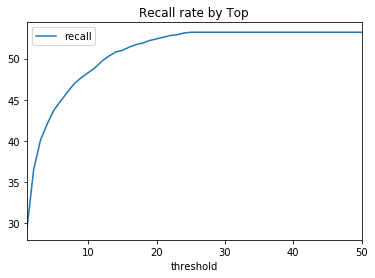

,records_count,true_positives,recall
threshold,,,
1,2435,1666,29.2
2,3124,2081,36.5
3,3527,2288,40.1
4,3791,2402,42.1
5,3993,2496,43.8
6,4173,2560,44.9
7,4333,2625,46.0
8,4488,2681,47.0
9,4600,2719,47.7


In [19]:
df = estimate_performance(results_df, 'rank', range(1, 51, 1), condition='lt')
df['recall'] = df.true_positives.apply(lambda x: round(x / float(gld_ev_sent_count) * 100, 1))
df[['recall']].plot.line(title='Recall rate by Top')
plt.show()
df.head(20)

## Evaluation

In [20]:
# modified score.py

import json
import sys

def score_py(predicted):
    NEI = 'NOT ENOUGH INFO'
    actual = json.load(open('devset.json'))
    #predicted = json.load(open('testoutput.json'))

    correct_label = num_instances = 0
    evidence_prec = num_eprec = 0
    evidence_recall = num_erec = 0
    doc_prec = num_dprec = 0
    doc_rec = num_drec = 0

    for ident, arecord in actual.items():
        precord = predicted[ident]

        alabel = arecord['label'].upper()
        plabel = precord['label'].upper()
        if alabel == plabel:
            correct_label += 1
        num_instances += 1

        if alabel != NEI:
            prec = prec_hits = 0
            #rec = 
            rec_hits = 0

            aes = {(doc_id, sent_id) for doc_id, sent_id in arecord['evidence']}
            pes = {(doc_id, sent_id) for doc_id, sent_id in precord['evidence'][:5]}
            #print()
            for pe in pes:
                #print(pe )
                if pe in aes:
                    prec += 1
                prec_hits += 1

            for ae in aes:
                #if ae in pes:
                #    rec += 1
                rec_hits += 1

            #assert prec == rec
            #print(aes)
            ads = set(map(lambda ds: ds[0], aes))
            #print(ads)
            last_pd = None
            dp = ndp = 0
            for pe in pes:
                if not last_pd or pe[0] != last_pd:
                    if pe[0] in ads:
                        dp += 1
                    ndp += 1
                last_pd = pe[0]

            pds = set(map(lambda ds: ds[0], pes))
            dr = ndr = 0
            for ae in ads:
                if ae in pds:
                    dr += 1
                ndr += 1

            if prec_hits > 0:
                evidence_prec += float(prec) / prec_hits
                num_eprec += 1

            if ndp > 0:
                doc_prec += float(dp) / ndp
                num_dprec += 1

            assert rec_hits > 0
            evidence_recall += float(prec) / rec_hits
            num_erec += 1

            assert ndr > 0
            doc_rec += float(dr) / ndr
            num_drec += 1


    accuracy = correct_label / float(num_instances)
    #print('Label Accuracy', '\t\t%.2f%%' % (100 * accuracy))

    precision = evidence_prec / float(num_eprec) if num_eprec != 0 else 0
    recall = evidence_recall / float(num_erec) if num_erec != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    #print('Sentence Precision', '\t%.2f%%' % (100 * precision))
    #print('Sentence Recall', '\t%.2f%%' % (100 * recall))
    #print('Sentence F1', '\t\t%.2f%%' % (100 * f1))

    doc_precision = doc_prec / float(num_dprec) if num_dprec != 0 else 0
    doc_recall = doc_rec / float(num_drec) if num_drec != 0 else 0
    doc_f1 = 2 * doc_precision * doc_recall / (doc_precision + doc_recall) if doc_precision + doc_recall > 0 else 0
    #print('Document Precision', '\t%.2f%%' % (100 * doc_precision))
    #print('Document Recall', '\t%.2f%%' % (100 * doc_recall))
    #print('Document F1', '\t\t%.2f%%' % (100 * doc_f1))
    
    return doc_recall, doc_precision, doc_f1, recall, precision, f1, accuracy

In [21]:
results_df['evidence'] = results_df.apply(lambda v: (v['found_doc'], v[sentence_col]), axis=1)

In [27]:
res = []
for rank in range(1, 26, 1):
    mask = (results_df['rank'] <= rank)
    submission_df = results_df[mask][['claim_id', 'evidence']]
    submission_df = submission_df.groupby('claim_id').agg(list)
    submission_df = submission_df.join(claims_df.claim)
    submission_df['label'] = "SUPPORTS"
    submission_df = claims_df.join(submission_df[['evidence', 'label']])

    submission_df['label'] = submission_df.label.fillna('NOT ENOUGH INFO')
    mask = submission_df.evidence.isna()
    submission_df.loc[mask, 'evidence'] = [[]] * sum(mask)

    submission_df.index = submission_df.reset_index().claim_id.astype(str).values

    predicted = submission_df.to_dict(orient='index')#to_json(orient='index')

    item = score_py(predicted)
    res.append(item)

In [28]:
doc_metrics = ['doc_recall', 'doc_prec', 'doc_f1']
sent_metrics = ['sent_recall', 'sent_prec', 'sent_f1']
cols = doc_metrics + sent_metrics + ['accuracy']
df = pd.DataFrame(res, columns=cols, index=range(1, len(res)+1))
df.index.name = 'Top'

In [29]:
df

,doc_recall,doc_prec,doc_f1,sent_recall,sent_prec,sent_f1,accuracy
Top,,,,,,,
1,0.49,0.98,0.65,0.44,0.95,0.60,0.39
2,0.59,0.97,0.73,0.54,0.94,0.68,0.40
3,0.64,0.96,0.77,0.58,0.92,0.71,0.40
4,0.66,0.96,0.78,0.60,0.91,0.73,0.40
5,0.68,0.96,0.79,0.62,0.91,0.73,0.40
6,0.69,0.95,0.80,0.63,0.90,0.74,0.39
7,0.71,0.95,0.81,0.64,0.89,0.75,0.40
8,0.72,0.95,0.82,0.65,0.89,0.75,0.39
9,0.73,0.95,0.82,0.65,0.88,0.75,0.39


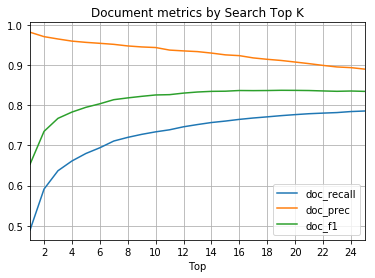

In [30]:
df[doc_metrics].plot.line(title='Document metrics by Search Top K',
                          grid=True, xticks=range(2,26,2))
plt.show()

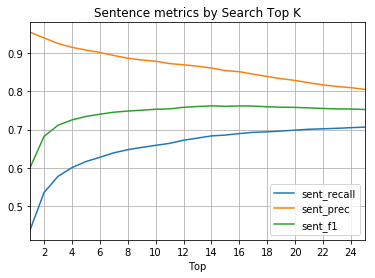

In [31]:
df[sent_metrics].plot.line(title='Sentence metrics by Search Top K',
                              grid=True, xticks=range(2,26,2))
plt.show()